# Práctica sobre algoritmos genéticos

Un área ferroviaria de carga/descarga con una única vía de entrada y otra salida se compone de tres muelles de carga/descarga: Op1, Op2 y Op3, correspondientes a contenedores, carbón y gas. Por tanto, cada tren que llega se dirige a un muelle en función de su carga. Un 
tren tarda en cargar o descargar un tiempo proporcional al número de vagones que arrastra. Cada día llegan secuencialmente n trenes. Si los trenes son de cargas distintas, pueden entrar en paralelo a los muelles. Cuando dos trenes con el mismo tipo de carga se encuentran seguidos, el segundo debe esperar por el primero, así como todos los demás que se encuentren por detrás.

In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [2]:
class Train:
    def __init__(self, wagons, op, licence_plate):
        self.wagons = wagons
        self.op = op
        self.licence_plate = licence_plate

    def __str__(self):
        return "Número de vagones:" + str(self.wagons) \
        + "\n" + "Muelle de operaciones:" + str(self.op) \
        + "\n" + "Matrícula:" + str(self.licence_plate)


def random_trains_generation(n):

    train_list = []

    
    for i in range(n):
        wagons = random.randint(10, 30)  # Cada tren puede arrastrar entre 10 y 30 vagones
        op = random.choice(["op1", "op2", "op3"])  # A cada tren se le asigna un tipo de carga
        train_list.append(Train(wagons, op, i))

    return train_list


In [3]:
trenes = random_trains_generation(25)

### Función de Fitness

In [4]:
def fitness_function(individual):

    tiempo_actual = {"op1": 0, "op2": 0, "op3": 0}
    tiempo_total = 0

    for pos in individual:
        tren = trenes[pos]

        #Ejecucuçión en paralelo
        if tiempo_actual[tren.op] == 0:
            tiempo_actual[tren.op] = tren.wagons
        
        #Ejecución en serie
        else:

            #Tiempo de espera del vagón de su tipo anterior
            tiempo_espera = tiempo_actual[tren.op]

            #Modificar los tiempos de espera de todos los tipos de vagones
            for tipo, tiempo in tiempo_actual.items():
                tiempo -= tiempo_espera

                #Si el tiempo es negativo, se pone a 0
                if tiempo < 0:
                    tiempo = 0
                
                #Modificar el tiempo de espera del tipo de vagón
                tiempo_actual[tipo] = tiempo

            tiempo_total += tiempo_espera
            tiempo_actual[tren.op] = tren.wagons
    
    #suma máximo de los tiempos restantes al acabar la lista de trenes
    tiempo_total += max(tiempo_actual.values())

    return tiempo_total,

### Mutación

In [5]:
def mutate(individual):
    
    pos = random.randint(0, len(individual)-1)
    pos2 = random.randint(0, len(individual)-1)

    while pos == pos2:
        pos2 = random.randint(0, len(individual)-1)

    individual[pos], individual[pos2] = individual[pos2], individual[pos]

    return individual,


### Cruce

In [6]:
def mate(train1, train2):
    
    corte = random.randint(0, len(train1)-1)
    
    train_inic, train_fin = train1[:corte], train1[corte:]
    train_inic2, train_fin2 = train2[:corte], train2[corte:]


    distintos_1 = set(train1) - (set(train_inic) | set(train_fin2))
    
    train_fin_new = []
    for train in train_fin2:
        if train not in train_inic:
            train_fin_new.append(train)
        else:
            train_fin_new.append(distintos_1.pop())
    
    distintos_2 = set(train2) - (set(train_inic2) | set(train_fin))

    train_fin2_new = []
    for train in train_fin:
        if train not in train_inic2:
            train_fin2_new.append(train)
        else:
            train_fin2_new.append(distintos_2.pop())
    
    subtrain1 = train_fin_new + train_inic
    subtrain2 = train_fin2_new + train_inic2

    return creator.Individual(subtrain1), creator.Individual(subtrain2)

### Individuos

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #minimizar el tiempo de trenes
creator.create("Individual", list, fitness=creator.FitnessMin)

### Configuración para utilizar el algoritmo genético.

- Generar una muestra aleatoria de índices en el rango de 0 a len(trenes) 

- Crear un individuo de la clase creator.Individual utilizando la función previamente registrada "indices"

- Crear una población de tipo list utilizando la función previamente registrada "individual"

- Función **_fitness_function_** para evaluar la aptitud (fitness) de un individuo

- Función **_mate_** para realizar la recombinación (crossover) de dos individuos durante la etapa de reproducción del algoritmo genético

- Función **_mutate_** para realizar la mutación de un individuo durante la etapa de reproducción del algoritmo genético

- Selección de los individuos mediante el algoritmo NSGA-II basado en la evaluación de dominancia de Pareto (un individuo es considerado mejor que otro si mejora al menos en uno de los objetivos sin empeorar en ningún otro) y la asignación de rangos


In [8]:
toolbox = base.Toolbox()

toolbox.register("indices", random.sample, range(len(trenes)), len(trenes))

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_function)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selNSGA2)

In [9]:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda indiv: indiv.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)


### Hall of Fame

In [10]:
def main():
    NGEN = 30
    MU = 50
    LAMBDA = 100
    CXPB = 0.7
    MUTPB = 0.2

    pop = toolbox.population(n=MU)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

    return pop, hof, logbook

In [11]:
pop, hof, logbook = main()

gen	nevals	avg     	std          	min   	max   
0  	50    	[259.36]	[20.50537491]	[206.]	[300.]
1  	90    	[233.14]	[10.63768772]	[206.]	[249.]
2  	86    	[221.84]	[5.79434207] 	[206.]	[230.]
3  	87    	[215.1] 	[4.60977223] 	[202.]	[220.]
4  	85    	[210.44]	[4.54383098] 	[197.]	[216.]
5  	91    	[206.12]	[3.72902132] 	[197.]	[212.]
6  	92    	[202.42]	[3.74213843] 	[192.]	[206.]
7  	91    	[199.74]	[3.52596086] 	[192.]	[204.]
8  	91    	[197.68]	[2.65661439] 	[192.]	[201.]
9  	91    	[195.52]	[2.07113495] 	[192.]	[198.]
10 	92    	[194.52]	[2.04195984] 	[192.]	[197.]
11 	93    	[192.92]	[1.05527248] 	[192.]	[195.]
12 	90    	[192.18]	[0.38418745] 	[192.]	[193.]
13 	89    	[192.]  	[0.]         	[192.]	[192.]
14 	92    	[192.]  	[0.]         	[192.]	[192.]
15 	89    	[192.]  	[0.]         	[192.]	[192.]
16 	93    	[192.]  	[0.]         	[192.]	[192.]
17 	90    	[192.]  	[0.]         	[192.]	[192.]
18 	90    	[192.]  	[0.]         	[192.]	[192.]
19 	87    	[192.]  	[0.]         	[192.]

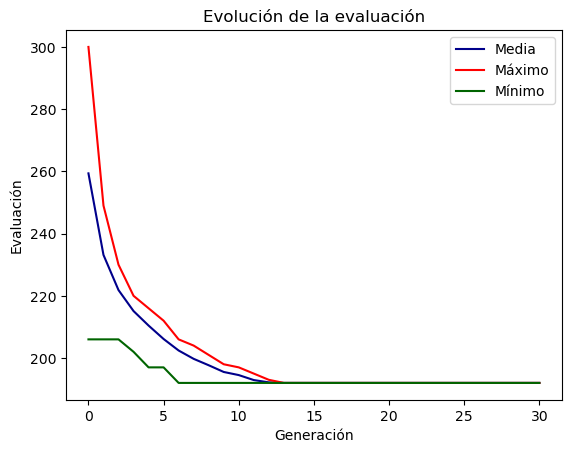

In [12]:
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="Media", c = "darkblue")
plt.plot(gen, max_, label="Máximo", c = "red")
plt.plot(gen, min_, label="Mínimo", c = "darkgreen")

plt.xlabel("Generación")
plt.ylabel("Evaluación")
plt.title("Evolución de la evaluación")
plt.legend()
plt.show()

### Comprobación que no existen repeticiones de trenes

In [14]:
print("Configuración ordenada de trenes:" , sorted(hof[0]))
print("Número de elementos distintos:" ,len(set(hof[0])))

Configuración ordenada de trenes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Número de elementos distintos: 25


### Tiempo que tardaría si los trenes se ejecutaran en paralelo sin esperar

In [20]:
tiempos_operaciones = {"op1": 0, "op2": 0, "op3": 0}

for train in trenes:
    tiempos_operaciones[train.op] += train.wagons

print("Tiempo mínimo de descarga del individuo ideal: " , max(tiempos_operaciones.values()))
print("Tiempo calculado por el algoritmo genético: ", hof[0].fitness.values[0])
print("Configuración de trenes: ", hof[0])

Tiempo mínimo de descarga del individuo ideal:  218
Tiempo calculado por el algoritmo genético:  218.0
Configuración de trenes:  [8, 11, 24, 18, 14, 13, 21, 17, 16, 1, 5, 22, 7, 23, 0, 19, 15, 9, 20, 6, 10, 4, 3, 2, 12]
